In [1]:
!python --version


Python 3.10.12


In [ ]:
!pip install gpflow
!pip install utils


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 10.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from glob import glob

import tensorflow as tf
import gpflow
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Utilis


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob


def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

def prepare_predictand(data_sets,data_path,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    Y_all = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"outputs_{file}.nc"))
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))

    return Y, length_all


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [ ]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [ ]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [ ]:
X_train_xr

<xarray.Dataset>
Dimensions:    (time: 753, longitude: 144, latitude: 96)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 745 746 747 748 749 750 751 752
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    CO2        (time) float64 0.1883 0.3772 0.5738 ... 1.465e+03 1.5e+03
    SO2        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CH4        (time) float64 0.03131 0.03174 0.03218 ... 0.3665 0.3698 0.3712
    BC         (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [ ]:
df = X_train_xr["SO2"].to_dataframe()

In [ ]:
import pandas as pd

# Select multiple variables from xarray Dataset
variables = ["CO2", "CH4", "SO2", "BC"]
selected_data = X_train_xr[variables]

# Convert selected variables to pandas DataFrame
df = selected_data.to_dataframe()

In [ ]:
index=X_train_xr["CO2"].coords['time'].data

In [ ]:
co2 = X_train_xr["CO2"].data
ch4 = X_train_xr["CH4"].data
so2 = X_train_xr["SO2"].data
bc = X_train_xr["BC"].data

In [ ]:
X_train_df = pd.DataFrame({"CO2":co2, "CH4": ch4}, index=X_train_xr["CO2"].coords['time'].data)

In [ ]:
X_train_df = pd.DataFrame({"SO2":so2, "BC": bc}, index=X_train_xr["CO2"].coords['time'].data)

ValueError: ignored

In [ ]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                           #"SO2": X_train_xr["SO2"].data
                           #"BC" : X_train_xr["BC"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

In [ ]:
# Standardize the predictors
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test  = X_test_df.to_numpy()

In [ ]:
# Standardize the predictand
y_train    = y_train_df.to_numpy().astype(np.float64)
train_tas_mean, train_tas_std = y_train.mean(), y_train.std()
y_train    = (y_train - train_tas_mean) / train_tas_std


print(X_train.shape,y_train.shape,X_test.shape)

(753, 2) (753, 13824) (86, 2)


In [ ]:
# Define the kernels Matern32, full list here https://gpflow.github.io/GPflow/develop/api/gpflow/kernels/index.html
#gpflow.kernels.Matern32
#class gpflow.kernels.Matern32(variance=1.0, lengthscales=1.0, **kwargs)[source]
#Bases: IsotropicStationary
#The Matern 3/2 kernel. Functions drawn from a GP with this kernel are once differentiable. The kernel equation is
#k(r) = σ² (1 + √3r) exp{-√3 r}

#kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
#kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

# The Exponential kernel. It is equivalent to a Matern12 kernel with doubled lengthscales
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])


kernel = kernel_CO2 + kernel_CH4

# Define the model
np.random.seed(5)
mean  = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train, y_train),
                          kernel=kernel,
                          mean_function=mean)

# Define optimizer
opt = gpflow.optimizers.Scipy()

In [ ]:
# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4401108.245389176
        x: [ 5.017e+00  4.592e+00 -1.236e+00 -3.492e+00 -2.008e+00
             8.274e-01]
      nit: 36
      jac: [-2.152e+00  1.626e+00  5.056e+00 -2.963e+00  4.668e-01
             3.043e+00]
     nfev: 47
     njev: 47
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [ ]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test)
posterior_mean   = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std    = np.sqrt(standard_posterior_var) * train_tas_std

In [ ]:
y_test_pre_mean = np.reshape(posterior_mean,[posterior_mean.shape[0], 96, 144])
y_test_pre_std  = np.reshape(posterior_std,[posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values,
                                 'latitude': X_test_xr.latitude.values,
                                 'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean),
                                            tas_std=(['time', 'latitude', 'longitude'], y_test_pre_std)))

In [ ]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])
posterior_tas_data = xr.DataArray(posterior_tas, dims=y_test_xr.tas.dims, coords=y_test_xr.tas.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=y_test_xr.tas.dims, coords=y_test_xr.tas.coords)

In [ ]:
# Save predictions
posterior_tas_data.to_netcdf('/content/gdrive/MyDrive/climatebench-gpr-posterior-mean-dtr-test-2019-2100.nc')
posterior_tas_std_data.to_netcdf('/content/gdrive/MyDrive/climatebench-gpr-pposterior-std-dtr-test-2019-2100.nc')

In [ ]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 0.3030845450646366
RMSE at 2100: 0.3297314447483064
RMSE 2045-2055: 0.34500836870151735
RMSE 2090-2100: 0.3617038840470205
RMSE 2050-2100: 0.3604986696080974
RMSE average last 20y: 0.16791490453927432


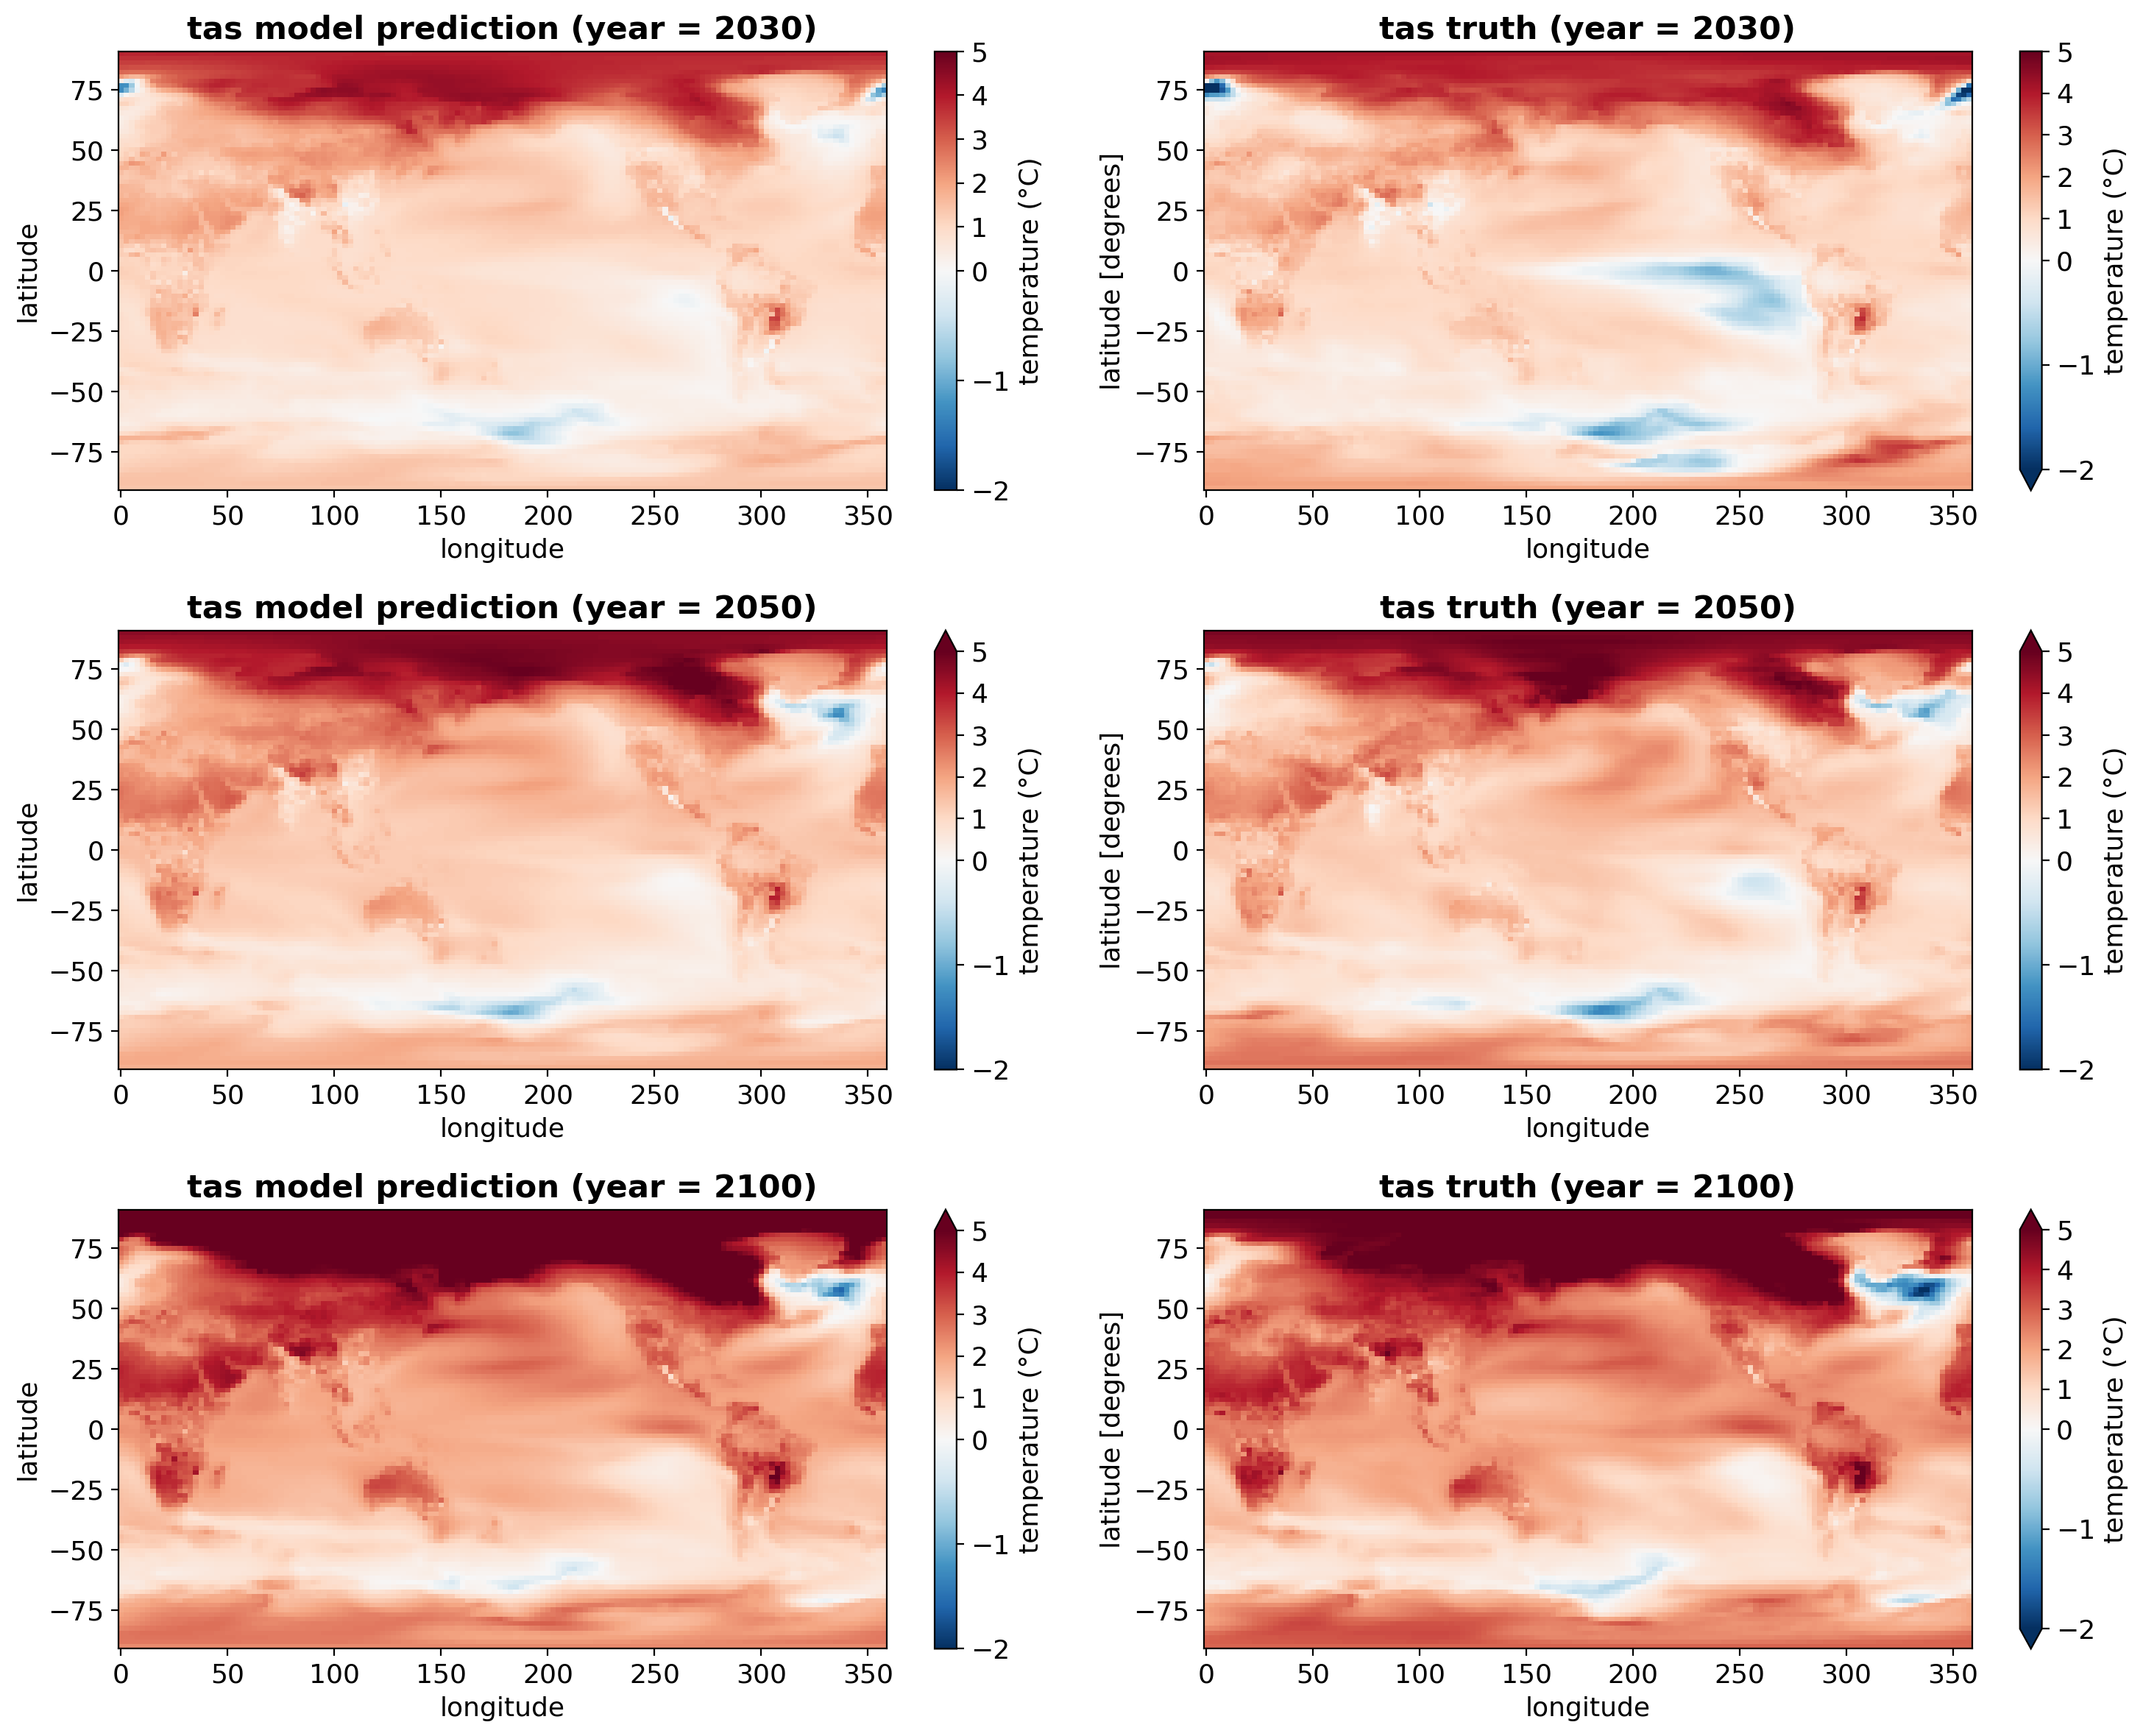

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

y_test_pre.tas_mean.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

In [ ]:
ClimateBench is a recently curated benchmarking dataset specifically designed for evaluating the performance of machine learning emulators in the field of climate science. It provides a standardized framework for comparing different machine learning models and their abilities to reproduce climate variables.This study focuses on evaluating non-linear regression models using the aforementioned ClimateBench dataset. Despite being considered fundamental, regression models offer several advantages.In particular, by leveraging the kernel trick, regression models can capture complex relationships and improve their predictive capabilities on the ClimateBench dataset. This work compares the evaluation of three non linear regression model. The Gaussian process regressor performed the best in the evaluation metric, however, Support Vector and Kernel Ridge delivers competitive results as well. Furthermore, we have been working on the idea of composite kernels to improve performance. ClimateBench is a recently curated benchmarking dataset specifically designed for evaluating the performance of machine learning emulators in the field of climate science. It provides a standardized framework for comparing different machine learning models and their abilities to reproduce climate variables.This study focuses on evaluating non-linear regression models using the aforementioned ClimateBench dataset. Despite being considered fundamental, regression models offer several advantages.In particular, by leveraging the kernel trick, regression models can capture complex relationships and improve their predictive capabilities on the ClimateBench dataset. This work compares the evaluation of three non linear regression model. The Gaussian process regressor performed the best in the evaluation metric, however, Support Vector and Kernel Ridge delivers competitive results as well. Furthermore, we have been working on the idea of composite kernels to improve performance. ClimateBench is a recently curated benchmarking dataset specifically designed for evaluating the performance of machine learning emulators in the field of climate science. It provides a standardized framework for comparing different machine learning models and their abilities to reproduce climate variables.This study focuses on evaluating non-linear regression models using the aforementioned ClimateBench dataset. Despite being considered fundamental, regression models offer several advantages.In particular, by leveraging the kernel trick, regression models can capture complex relationships and improve their predictive capabilities on the ClimateBench dataset. This work compares the evaluation of three non linear regression model. The Gaussian process regressor performed the best in the evaluation metric, however, Support Vector and Kernel Ridge delivers competitive results as well. Furthermore, we have been working on the idea of composite kernels to improve performance. ClimateBench is a recently curated benchmarking dataset specifically designed for evaluating the performance of machine learning emulators in the field of climate science. It provides a standardized framework for comparing different machine learning models and their abilities to reproduce climate variables.This study focuses on evaluating non-linear regression models using the aforementioned ClimateBench dataset. Despite being considered fundamental, regression models offer several advantages.In particular, by leveraging the kernel trick, regression models can capture complex relationships and improve their predictive capabilities on the ClimateBench dataset. This work compares the evaluation of three non linear regression model. The Gaussian process regressor performed the best in the evaluation metric, however, Support Vector and Kernel Ridge delivers competitive results as well. Furthermore, we have been working on the idea of composite kernels to improve performance. ClimateBench is a recently curated benchmarking dataset specifically designed for evaluating the performance of machine learning emulators in the field of climate science. It provides a standardized framework for comparing different machine learning models and their abilities to reproduce climate variables.This study focuses on evaluating non-linear regression models using the aforementioned ClimateBench dataset. Despite being considered fundamental, regression models offer several advantages.In particular, by leveraging the kernel trick, regression models can capture complex relationships and improve their predictive capabilities on the ClimateBench dataset. This work compares the evaluation of three non linear regression model. The Gaussian process regressor performed the best in the evaluation metric, however, Support Vector and Kernel Ridge delivers competitive results as well. Furthermore, we have been working on the idea of composite kernels to improve performance.